In [1]:
!pip install python-box

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 3.6 MB 12.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import math
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# 1. 학습 설정

In [4]:
config = {
    'data_path' : "./dataset" , # 데이터 경로

    'max_len' : 50,
    'hidden_units' : 50, # Embedding size
    'num_heads' : 4, # Multi-head layer 의 수 (병렬 처리)
    'num_layers': 2, # block의 개수 (encoder layer의 개수)
    'dropout_rate' : 0.5, # dropout 비율
    'lr' : 0.001,
    'batch_size' : 128,
    'num_epochs' : 100,
    'num_workers' : 2,
    'mask_prob' : 0.15, # for cloze task
}


device = 'cuda' if torch.cuda.is_available() else 'cpu'


config = Box(config)

# 2. 데이터 전처리

In [5]:
# 학습시에는 유저가 상호작용했던 맨 마지막 값을 제외한 나머지를 학습으로, 마지막 값은 test셋으로
class MakeSequenceDataSet():
    """
    SequenceData 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'ratings.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('movieId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieId'].apply(lambda x : self.item_encoder[x] + 1) # item은 1부터 생성.
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])
        self.df = self.df.sort_values(['user_idx', 'timestamp']) # 시간에 따라 정렬
        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())
        
        # 유저가 상호작용한 아이템을 나열.
        for user in users:
            user_train[user] = users[user][:-1]
            user_valid[user] = [users[user][-1]] # 마지막 아이템을 예측

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

In [6]:
# 학습시에는 유저가 상호작용했던 맨 마지막 값을 제외한 나머지를 학습으로, 마지막 값은 test셋으로
class MakeSequenceDataSet_finetunning():
    """
    SequenceData 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'oliveyoung.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('itemId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['itemId'].apply(lambda x : self.item_encoder[x] + 1)
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])
        self.df = self.df.sort_values(['user_idx', 'timestamp']) # 시간에 따라 정렬

        self.df = self.df.sort_values(['user_idx', 'timestamp']) # 시간에 따라 정렬
        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())
        
        # 유저가 상호작용한 아이템을 나열.
        for user in users:
            user_train[user] = users[user][:-1]
            user_valid[user] = [users[user][-1]] # 마지막 아이템을 예측

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

In [7]:
class BERTRecDataSet(Dataset):
    def __init__(self, user_train, max_len, num_user, num_item, mask_prob):
        self.user_train = user_train
        self.max_len = max_len
        self.num_user = num_user
        self.num_item = num_item
        self.mask_prob = mask_prob
        self._all_items = set([i for i in range(1, self.num_item + 1)])

    def __len__(self):
        # 총 user의 수 = 학습에 사용할 sequence의 수
        return self.num_user

    def __getitem__(self, user): 
        
        user_seq = self.user_train[user]
        tokens = []
        labels = []
        for s in user_seq[-self.max_len:]:
            prob = np.random.random()
            if prob < self.mask_prob:
                prob /= self.mask_prob
                if prob < 0.8:
                    # masking
                    tokens.append(self.num_item + 1)  # mask_index: num_item + 1, 0: pad, 1~num_item: item index
                elif prob < 0.9:
                    # noise
                    tokens.extend(self.random_neg_sampling(rated_item = user_seq, num_item_sample = 1))  # item random sampling
                else:
                    tokens.append(s)
                labels.append(s) # 학습에 사용 O
            else:
                tokens.append(s)
                labels.append(0) # 학습에 사용 X

        mask_len = self.max_len - len(tokens)
        tokens = [0] * mask_len + tokens
        labels = [0] * mask_len + labels

        return torch.LongTensor(tokens), torch.LongTensor(labels)

    def random_neg_sampling(self, rated_item : list, num_item_sample : int):
        nge_samples = random.sample(list(self._all_items - set(rated_item)), num_item_sample)
        return nge_samples

# 3. 모델

In [8]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, Q, K, V, mask):
        """
        Q, K, V : (batch_size, num_heads, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        """
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units) # (batch_size, num_heads, max_len, max_len)
        attn_score = attn_score.masked_fill(mask == 0, -1e9)  # 유사도가 0인 지점은 -infinity로 보내 softmax 결과가 0이 되도록 함
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1))  # attention distribution
        output = torch.matmul(attn_dist, V)  # (batch_size, num_heads, max_len, hidden_units) / # dim of output : batchSize x num_head x seqLen x hidden_units
        return output, attn_dist


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # head의 수
        self.hidden_units = hidden_units
        
        # query, key, value, output 생성을 위해 Linear 모델 생성
        self.W_Q = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_O = nn.Linear(hidden_units * num_heads, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate) # dropout rate
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, enc, mask):
        """
        enc : (batch_size, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        
        """
        residual = enc # residual connection을 위해 residual 부분을 저장
        batch_size, seqlen = enc.size(0), enc.size(1)

        # Query, Key, Value를 (num_head)개의 Head로 나누어 각기 다른 Linear projection을 통과시킴
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)

        # Head별로 각기 다른 attention이 가능하도록 Transpose 후 각각 attention에 통과시킴
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2) # (batch_size, num_heads, max_len, hidden_units)
        output, attn_dist = self.attention(Q, K, V, mask) # output : (batch_size, num_heads, max_len, hidden_units) / attn_dist : (batch_size, num_heads, max_len, max_len)

        # 다시 Transpose한 후 모든 head들의 attention 결과를 합칩니다.
        output = output.transpose(1, 2).contiguous() # (batch_size, max_len, num_heads, hidden_units) / contiguous() : 가변적 메모리 할당
        output = output.view(batch_size, seqlen, -1) # (batch_size, max_len, hidden_units * num_heads)

        # Linear Projection, Dropout, Residual sum, and Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual) # (batch_size, max_len, hidden_units)
        return output, attn_dist


class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()

        self.W_1 = nn.Linear(hidden_units, hidden_units)
        self.W_2 = nn.Linear(hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.relu(self.dropout(self.W_1(x))))
        output = self.layerNorm(self.dropout(output) + residual)
        return output


class BERT4RecBlock(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(BERT4RecBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist


class BERT4Rec(nn.Module):
    def __init__(self, num_user, num_item, hidden_units, num_heads, num_layers, max_len, dropout_rate, device):
        super(BERT4Rec, self).__init__()

        self.num_user = num_user
        self.num_item = num_item
        self.hidden_units = hidden_units
        self.num_heads = num_heads
        self.num_layers = num_layers 
        self.device = device
        
        self.item_emb = nn.Embedding(num_item + 2, hidden_units, padding_idx=0) # padding : 0 / item : 1 ~ num_item + 1 /  mask : num_item + 2
        self.pos_emb = nn.Embedding(max_len, hidden_units) # learnable positional encoding
        self.dropout = nn.Dropout(dropout_rate)
        self.emb_layernorm = nn.LayerNorm(hidden_units, eps=1e-6)
        
        self.blocks = nn.ModuleList([BERT4RecBlock(num_heads, hidden_units, dropout_rate) for _ in range(num_layers)])
        self.out = nn.Linear(hidden_units, num_item + 1)
    
    def forward(self, log_seqs):
        """
        log_seqs : (batch_size, max_len)

        ex)
        log_seqs = [
                [1, 2, 3, 4, 5],
                [0, 0, 0, 1, 2],
                [0, 0, 1, 2, 3]
        ]
        
        """
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.device)) # (batch_size, max_len, hidden_units)
        positions = np.tile(np.array(range(log_seqs.shape[1])), [log_seqs.shape[0], 1]) # (batch_size, max_len)
        seqs += self.pos_emb(torch.LongTensor(positions).to(self.device)) # (batch_size, max_len, hidden_units)
        seqs = self.emb_layernorm(self.dropout(seqs)) # LayerNorm

        mask_pad = torch.BoolTensor(log_seqs > 0).unsqueeze(1).repeat(1, log_seqs.shape[1], 1).unsqueeze(1).to(self.device) # mask for zero pad / (batch_size, 1, max_len, max_len)
        for block in self.blocks:
            seqs, attn_dist = block(seqs, mask_pad)
        out = self.out(seqs) # (batch_size, max_len, num_item + 1)
        return out

# 4. 학습 함수

In [9]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    loss_val = 0
    for seq, labels in tqdm(data_loader):
        logits = model(seq)

        logits = logits.view(-1, logits.size(-1))
        labels = labels.view(-1).to(device)

        optimizer.zero_grad()
        loss = criterion(logits, labels)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()
    
    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, user_train, user_valid, max_len, bert4rec_dataset, make_sequence_dataset,types):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10
    
    if types == 'training':
        num_item_sample = 100
    else:
        num_item_sample = 10

    users = [user for user in range(make_sequence_dataset.num_user)]

    for user in tqdm(users):
        seq = (user_train[user] + [make_sequence_dataset.num_item + 1])[-max_len:]
        rated = user_train[user] + user_valid[user]
        items = user_valid[user] + bert4rec_dataset.random_neg_sampling(rated_item = rated, num_item_sample = num_item_sample)
        
        with torch.no_grad():
            predictions = -model(np.array([seq]))
            predictions = predictions[0][-1][items] # sampling
            rank = predictions.argsort().argsort()[0].item()

        if rank < 10: #Top10
            NDCG += 1 / np.log2(rank + 2)
            HIT += 1

    NDCG /= len(users)
    HIT /= len(users)

    return NDCG, HIT

# 5. 학습

In [24]:
make_sequence_dataset = MakeSequenceDataSet(config = config)
user_train, user_valid = make_sequence_dataset.get_train_valid_data()

In [25]:
bert4rec_dataset = BERTRecDataSet(
    user_train = user_train, 
    max_len = config.max_len, 
    num_user = make_sequence_dataset.num_user, 
    num_item = make_sequence_dataset.num_item,
    mask_prob = config.mask_prob
    )

In [26]:
data_loader = DataLoader(
    bert4rec_dataset, 
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [27]:
model = BERT4Rec(
    num_user = make_sequence_dataset.num_user, 
    num_item = make_sequence_dataset.num_item, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    max_len = config.max_len, 
    dropout_rate = config.dropout_rate, 
    device = device,
    ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) # label이 0인 경우 무시
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [ ]:
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        train_loss = train(
            model = model, 
            criterion = criterion, 
            optimizer = optimizer, 
            data_loader = data_loader)
            
        ndcg, hit = evaluate(
            model = model, 
            user_train = user_train, 
            user_valid = user_valid, 
            max_len = config.max_len,
            bert4rec_dataset = bert4rec_dataset, 
            make_sequence_dataset = make_sequence_dataset,
            types = 'training'
            )

        loss_list.append(train_loss)
        ndcg_list.append(ndcg)
        hit_list.append(hit)

        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')
        
    torch.save(model,f'./checkpoint/BERT4Rec_{epoch}.pth')
    print('checkpoint save!')

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

ax[0].plot(loss_list)
ax[0].set_title('Loss')

ax[1].plot([95,96,97,98,99,100],ndcg_list)
ax[1].set_title('NDCG')

ax[2].plot([95,96,97,98,99,100],hit_list)
ax[2].set_title('HIT')
plt.show()

### Fine-tunning

In [18]:
make_sequence_dataset_oliveyoung = MakeSequenceDataSet_finetunning(config = config)
user_train, user_valid = make_sequence_dataset_oliveyoung.get_train_valid_data()

In [19]:
bert4rec_dataset_oliveyoung = BERTRecDataSet(
    user_train = user_train, 
    max_len = config.max_len, 
    num_user = make_sequence_dataset_oliveyoung.num_user, 
    num_item = make_sequence_dataset_oliveyoung.num_item,
    mask_prob = config.mask_prob,
    )

In [20]:
data_finetunning_loader = DataLoader(
    bert4rec_dataset_oliveyoung, 
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [21]:
model = BERT4Rec(
    num_user = make_sequence_dataset_oliveyoung.num_user, 
    num_item = make_sequence_dataset_oliveyoung.num_item, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    max_len = config.max_len, 
    dropout_rate = config.dropout_rate, 
    device = device,
    ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) # pading 토큰은 무시
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [22]:
print(model)

BERT4Rec(
  (item_emb): Embedding(56, 50, padding_idx=0)
  (pos_emb): Embedding(50, 50)
  (dropout): Dropout(p=0.5, inplace=False)
  (emb_layernorm): LayerNorm((50,), eps=1e-06, elementwise_affine=True)
  (blocks): ModuleList(
    (0): BERT4RecBlock(
      (attention): MultiHeadAttention(
        (W_Q): Linear(in_features=50, out_features=200, bias=False)
        (W_K): Linear(in_features=50, out_features=200, bias=False)
        (W_V): Linear(in_features=50, out_features=200, bias=False)
        (W_O): Linear(in_features=200, out_features=50, bias=False)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.5, inplace=False)
        )
        (dropout): Dropout(p=0.5, inplace=False)
        (layerNorm): LayerNorm((50,), eps=1e-06, elementwise_affine=True)
      )
      (pointwise_feedforward): PositionwiseFeedForward(
        (W_1): Linear(in_features=50, out_features=50, bias=True)
        (W_2): Linear(in_features=50, out_features=50, bias=True)
        (d

In [23]:
# 파라미터 freeze
pretrained_model = torch.load('./checkpoint/BERT4Rec_42.pth')


new_state_dict = model.state_dict()
for name,param in pretrained_model.named_parameters():
    if name not in  ['item_emb.weight','out.weight','out.bias']:
        new_state_dict[name] = param

model.load_state_dict(new_state_dict)
    
# 첫번째 embedding layer와 마지막 linear layer 부분만 가중치 update
for name ,param in model.named_parameters():
    if name not in  ['item_emb.weight','out.weight','out.bias']:
        param.requires_grad = False
    print(name,':',param.requires_grad)

item_emb.weight : True
pos_emb.weight : False
emb_layernorm.weight : False
emb_layernorm.bias : False
blocks.0.attention.W_Q.weight : False
blocks.0.attention.W_K.weight : False
blocks.0.attention.W_V.weight : False
blocks.0.attention.W_O.weight : False
blocks.0.attention.layerNorm.weight : False
blocks.0.attention.layerNorm.bias : False
blocks.0.pointwise_feedforward.W_1.weight : False
blocks.0.pointwise_feedforward.W_1.bias : False
blocks.0.pointwise_feedforward.W_2.weight : False
blocks.0.pointwise_feedforward.W_2.bias : False
blocks.0.pointwise_feedforward.layerNorm.weight : False
blocks.0.pointwise_feedforward.layerNorm.bias : False
blocks.1.attention.W_Q.weight : False
blocks.1.attention.W_K.weight : False
blocks.1.attention.W_V.weight : False
blocks.1.attention.W_O.weight : False
blocks.1.attention.layerNorm.weight : False
blocks.1.attention.layerNorm.bias : False
blocks.1.pointwise_feedforward.W_1.weight : False
blocks.1.pointwise_feedforward.W_1.bias : False
blocks.1.pointwise

In [24]:
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        train_loss = train(
            model = model, 
            criterion = criterion, 
            optimizer = optimizer, 
            data_loader = data_finetunning_loader)
        
        ndcg, hit = evaluate(
            model = model, 
            user_train = user_train, 
            user_valid = user_valid, 
            max_len = config.max_len,
            bert4rec_dataset = bert4rec_dataset_oliveyoung, 
            make_sequence_dataset = make_sequence_dataset_oliveyoung,
            types = 'finetunning'
            )

        loss_list.append(train_loss)
        ndcg_list.append(ndcg)
        hit_list.append(hit)

        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')
        
    torch.save(model,f'./checkpoint/BERT4Rec_finetunning{epoch}.pth')
    print('checkpoint save!')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

checkpoint save!


Process Process-273:
Process Process-201:
Traceback (most recent call last):
Process Process-274:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/worker.py", line 306, in _worker_loop
    if done_event.is_set():
  File "/usr/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/local/lib/python3.8/dist-pa

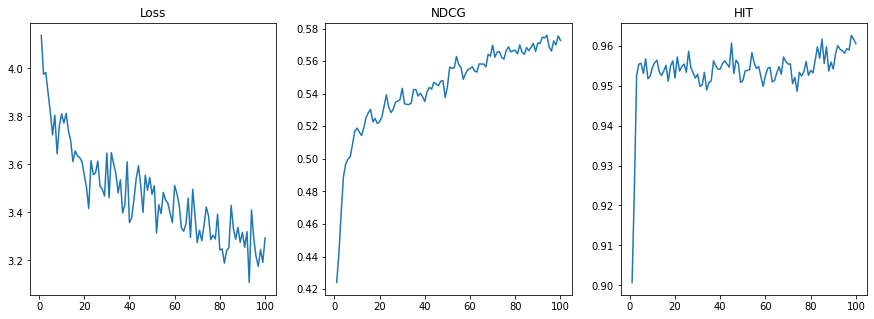

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

ax[0].plot(epochs,loss_list)
ax[0].set_title('Loss')

ax[1].plot(epochs,ndcg_list)
ax[1].set_title('NDCG')

ax[2].plot(epochs,hit_list)
ax[2].set_title('HIT')
plt.show()

### Inference

In [26]:
def inference(model, dataloader, sequence_dataset,top_n = 5):
    model.eval()
    result = []
    prediction_value = []
    with torch.no_grad():
        for seq in tqdm(dataloader):
            prediction = model(seq)
            
            # mask 토큰에 대한 예측값을 가져옴.
            masked_pred = prediction[-1,-1].detach().cpu().numpy()
            sorted_predicted = np.argsort(masked_pred).tolist()[::-1]
            
            # 마지막 item_id가 0과 56인 것은 padding, mask된 아이템이어서 제외
            sorted_predicted_ids = [sequence_dataset.item_decoder[itemid] for itemid in sorted_predicted[:top_n+1] if itemid not in seq and itemid not in [0,56]] 
            result.append(sorted_predicted_ids)
            prediction_value.append(masked_pred)

    return result,prediction_value

In [27]:
# inference시에는 user가 상호작용한 아이템은 살려두고 나머지는 masking처리.

class MakeSequenceDataSet_inference():
    """
    SequenceData 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'oliveyoung.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('itemId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['itemId'].apply(lambda x : self.item_encoder[x] + 1)
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])
        self.df = self.df.sort_values(['user_idx', 'timestamp']) # 시간에 따라 정렬


    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_data = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())
        
        for user in users:
            user_data[user] = users[user]

        return user_data
    

In [28]:
# 데이터셋 재구성
class BERTRecDataSet_inference(Dataset):
    def __init__(self, user_inference, max_len, num_user, num_item):
        self.user_inference = user_inference
        self.max_len = max_len
        self.num_user = num_user
        self.num_item = num_item
        self._all_items = set([i for i in range(1, self.num_item + 1)])

    def __len__(self):
        # 총 user의 수 = 학습에 사용할 sequence의 수
        return self.num_user

    def __getitem__(self, user): 
        
        user_seq = self.user_inference[user]
        tokens = [s for s in user_seq[-self.max_len:]] # 최근에 상호작용한 아이템이 마지막에 오도록
            
        # masking token append
        tokens.append(self.num_item + 1)  # mask_index: num_item + 1, 0: pad, 1~num_item: item index
                
        pad_len = self.max_len - len(tokens)
        tokens = [0] * pad_len + tokens

        return torch.LongTensor(tokens)

In [29]:
make_sequence_dataset_inference = MakeSequenceDataSet_inference(config = config )
inference_set = make_sequence_dataset_inference.generate_sequence_data()

In [30]:
bert4rec_dataset_inference = BERTRecDataSet_inference(
    user_inference = inference_set, 
    max_len = config.max_len, 
    num_user = make_sequence_dataset_inference.num_user, 
    num_item = make_sequence_dataset_inference.num_item,
    )

In [31]:
data_loader_inference = DataLoader(
    bert4rec_dataset_inference, 
    batch_size = 1, 
    shuffle = False, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [33]:
model = torch.load('./checkpoint/BERT4Rec_finetunning100.pth')

result,prediction_value = inference(model,data_loader_inference,make_sequence_dataset_inference,top_n = 5)

Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 1307) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.


  0%|          | 0/6277 [00:16<?, ?it/s]

In [39]:
# 상위 5개 아이템 추천 결과
oliveyoung = pd.read_csv('./dataset/oliveyoung.csv')
user = oliveyoung.userId.unique()
recommend_result = pd.DataFrame({'userId':user,'top_5_recommendation':result,'predict_value':prediction_value})
recommend_result


pd.merge(oliveyoung,recommend_result).to_csv('./result/oliveyoung_recommend_result_bert4rec.csv',index=False)

In [15]:
import pandas as pd
result = pd.read_csv('./result/oliveyoung_recommend_result_bert4rec.csv')

user_recommend_bert4rec = pd.DataFrame(result.groupby('userId').top_5_recommendation.sum())
user_recommend_bert4rec.to_csv('./result/user_recommend_bert4rec.csv',index= False,encoding = 'cp949')
user_recommend_bert4rec

,top_5_recommendation
userId,
M0000000004414,"['레이즈 클래식 감자칩 42.5g', '[1+1기획]페리페라 잉크블랙카라', '3..."
M0000000005463,"['에뛰드 컬픽스 마스카라 ', '[단독기획] 쏘피 유기농 라베르플랑 생리대 중형 ..."
M0000000015086,"['에뛰드 컬픽스 마스카라 ', '고려은단 알티지 오메가3 60캡슐 (60일분)',..."
M0000000018226,"['C08""', '3CE 무드레시피 매트 립 컬러', '[선우PICK]메디힐 티트리..."
M0000000021605,"['C04', '고려은단 알티지 오메가3 60캡슐 (60일분)', '[단독기획] 쏘..."
...,...
M0000022073510,"['C06""', '에뛰드 컬픽스 마스카라 ', 'C08""', 'C07', '고려은단..."
M0000022085992,"['C04', '고려은단 알티지 오메가3 60캡슐 (60일분)', '라이아 모발코어..."
M0000022092643,"['C06""', '에뛰드 컬픽스 마스카라 ', 'C08""', 'C07', '고려은단..."


## 참고

- https://github.com/SeongBeomLEE/RecsysTutorial/blob/main/BERT4Rec/BERT4Rec.ipynb

- Pretrain(Movie-Lens 25M) epoch : 42 (원래는 100까지 학습해야함..) | Finetunning(Oliveyoung)_epoch : 100
    
    - finetunning 모델 최종 성능
        
        - Epoch: 100| Train loss: 3.29388| NDCG@10: 0.57268| HIT@10: 0.96049

        - num_item = 54 